In [1]:
import sys; sys.path.append('..')
import pyzx as zx
import random
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

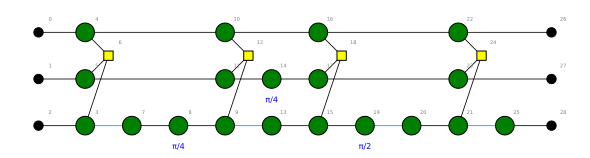

In [9]:
g = zx.qasm("""
qreg q[3];

ccz q[0],q[1],q[2];
h q[2];
t q[2];
ccz q[0],q[1],q[2];
h q[2];
t q[1];
ccz q[0],q[1],q[2];
s q[2];
ccx q[0],q[1],q[2];
""").to_graph(zh=True)
zx.draw(g, labels=True)

spider_simp: 4. 3. 3.  3 iterations
[(28, [2], [], [[4, 5]], [(Fraction(1, 1), [13]), (Fraction(1, 4), []), (Fraction(1, 1), [5, 4])])]


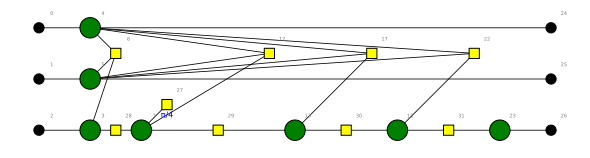

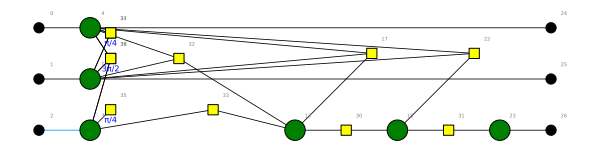

In [3]:
h = g.copy()
zx.simplify.spider_simp(h)
zx.hsimplify.to_hbox(h)
m = zx.hrules.match_hpivot(h)
print(m)
display(zx.draw(h,labels=True))
zx.hrules.hpivot(h,m)
display(zx.draw(h,labels=True))

In [11]:
zx.hsimplify.hpivot_simp(g)
zx.d3.draw(g, labels=True)